## 3.Project/homework

Multiclass and one-vs-all.

In chapter 1 we've created a multiclass classifier for MNIST dataset. Please create a classifier with a strategy known as one-vs-all.
It means you should create 10 separate classifiers, each for a single class.

Build and train the smallest possible (by the number of trainable weights) classifiers with an F1 (macro) score at 0.97 level.

Compare the number of total weights for 10 classifiers one-vs-all and 1 multi-classifier.

**This homework is obligatory. Please send colab link to kwant@agh.edu.pl before 08.05.2024.**

In [1]:
!wget -nc https://raw.githubusercontent.com/MenosGrandes/AI_ML_Course/main/requirements.txt


File ‘requirements.txt’ already there; not retrieving.



In [2]:
!pip install -r requirements.txt
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
import pandas as pd
import numpy as np
import platform
import pandas as pd
import numpy as np
import warnings
import sys;
#define Seaborn color palette to use
import numpy as np
from math import ceil
from itertools import zip_longest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import missingno as msno
import re
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np





2024-04-30 15:13:57.810628: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 15:13:57.810992: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 15:13:57.813304: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 15:13:57.840724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 15:13:58.555198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:

import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level="NOTSET", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)

logger = logging.getLogger("rich")


In [4]:
v = platform.python_version_tuple();
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 1000

In [5]:

# import MNIST dataset
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255       # 784 = 28*28
x_valid = x_valid.reshape(10000, 784).astype('float32') / 255

logger.info('x_train size: ' + str(x_train.shape))

[15:13:59] INFO     x_train size: (60000, 784)                                                      ]8;id=159510;file:///tmp/ipykernel_124827/1544249798.py\1544249798.py]8;;\:]8;id=610447;file:///tmp/ipykernel_124827/1544249798.py#6\6]8;;\

In [6]:
#@title Display MNIST data
def plot_mnist(images, labels):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8), sharex='col', sharey='row')
    for x in range(4):
        for y in range(4):
            idx = random.randint(0, images.shape[0]-1)
            img = images[idx].reshape(28, 28)
            truth = labels[idx]
            ax[x,y].imshow(img, cmap='gray')
            ax[x,y].set_title(str(truth))



In [7]:
# Hyperparameters!
from typing import NamedTuple
class HyperParameters(NamedTuple):
    droputs : float
    output_layers : int
    epochs :int
    bach_size : int
    input_dim :int


In [8]:
class ModelWrapper:
    def __init__(self,name, model,x_valid,y_valid,hyperparams):
        self.__model = model;
        self.__x_valid = x_valid
        self.__y_valid = y_valid
        self.__name = name
        self.__hyperparameters = hyperparams;
        self.__pred()
        self.__is_fit = False;
        
    def __pred(self):
        self.__y_valid_pred = np.argmax(self.__model.predict(self.__x_valid), axis=1)

    def plot_confusion_matrix(self):
        _cm = confusion_matrix(self.__y_valid, self.__y_valid_pred)
        _cmp = ConfusionMatrixDisplay(confusion_matrix=_cm,
                                      display_labels=list(range(len(np.unique(y_valid)))))
        _fig, _ax = plt.subplots(figsize=(8, 8))
        _cmp.plot(ax=_ax)
        _fig.show()        

    def plot_overfitting(self):
        plt.figure(figsize=(13, 5))
        plt.plot(self.__history.history['accuracy'])
        plt.plot(self.__history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['Train','Test'])
        plt.grid()
        plt.show()

    def summarise(self):
        if self.__is_fit is True:
            self.__pred()
            logger.info(f'{self.__name} | Model summary:\n')
            self.__model.summary()
            logger.info(f'{self.__name} | Classification report: \n')
            self.__pred()
            logger.info(f'{classification_report(self.__y_valid, self.__y_valid_pred)}')

            self.plot_confusion_matrix()
            self.plot_overfitting()
        else:
            logger.error(f"You should fit model first!")
            
    def fit(self,_x_train, _y_train):
        logger.info(f'{self.__name} | Model fitting!')

        self.__history = self.__model.fit(_x_train, _y_train,
                    batch_size=self.__hyperparameters.bach_size,
                    epochs=self.__hyperparameters.epochs,
                    validation_data=(self.__x_valid, self.__y_valid),
                    verbose=0)
        self.__is_fit = True
        
        




In [9]:

def build_base_multiclassification_model(hyperparams, name):
    model = tf.keras.Sequential(name=name)
    model.add(Input((hyperparams.input_dim,)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(hyperparams.droputs))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(hyperparams.droputs))
    model.add(Dense(hyperparams.output_layers, activation = 'sigmoid'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# History of above cell.
When I have added the droput layet, the accuracy dropped from 98.2% to 97.6, BUT its no longer overfitted ( based on the graph drawed at later cell ), so I think it's a lot better.

In [10]:

base_hyperparams = HyperParameters(droputs = 0.2,output_layers = 10,epochs = 10 ,bach_size = 16,input_dim =784)

In [11]:
base_model_name = "MultimClassClassificationBaseModel"
multiclassification_base_model = build_base_multiclassification_model(base_hyperparams,base_model_name)


In [12]:
models = []
models.append(ModelWrapper(base_model_name, multiclassification_base_model,x_valid,y_valid, base_hyperparams))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


In [13]:
models[0].fit(x_train,y_train)


           INFO     MultimClassClassificationBaseModel | Model fitting!                            ]8;id=596413;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=540967;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


[15:14:58] INFO     MultimClassClassificationBaseModel | Model summary:                            ]8;id=873848;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=210265;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "MultimClassClassificationBaseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,182 (985.09 KB)

 Trainable params: 84,060 (328.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,122 (656.73 KB)

           INFO     MultimClassClassificationBaseModel | Classification report:                    ]8;id=426437;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=271394;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


[15:14:59] INFO                   precision    recall  f1-score   support                          ]8;id=958460;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=136941;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.98      0.99      0.98       980                                          
                               1       0.98      1.00      0.99      1135                                          
                               2       0.97      0.98      0.98      1032                                          
                               3       0.96      0.98      0.97      1010                                          
                               4       0.97      0.98      0.98       982                                          
                               5       0.98      0.96      0.97       892                                          
                               6       0.97      0.98      0.98       958                                          
                               7       0.97      0.97      0.97      1028                                          
                               8       0.98      0.95      0.97       974                                          
                               9       0.98      0.96      0.97      1009                                          
                                                                                                                   
                        accuracy                           0.97     10000                                          
                       macro avg       0.97      0.97      0.97     10000                                          
                    weighted avg       0.97      0.97      0.97     10000                                          
                                                                                                                   

           DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.         ]8;id=849213;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/pyplot.py\pyplot.py]8;;\:]8;id=349410;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/pyplot.py#414\414]8;;\

           DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.         ]8;id=39077;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/pyplot.py\pyplot.py]8;;\:]8;id=327473;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/pyplot.py#414\414]8;;\

           DEBUG    findfont: Matching                                                         ]8;id=170374;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=338463;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1411\1411]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    10.0.                                                                                          

           DEBUG    findfont:                                                                  ]8;id=254005;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=667275;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf',                                            
                    name='STIXSizeFiveSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=901259;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=787819;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal',                          
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=610077;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=736044;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu                          
                    Sans', style='oblique', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 1.335                                                                      

           DEBUG    findfont:                                                                  ]8;id=171430;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=282880;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=270097;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=713647;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans',                       
                    style='oblique', variant='normal', weight=400, stretch='normal',                               
                    size='scalable')) = 1.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=983414;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=716651;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu                          
                    Serif', style='italic', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=989831;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=977789;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans                        
                    Mono', style='normal', variant='normal', weight=700, stretch='normal',                         
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=976999;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=806765;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=908274;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=123983;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral',                        
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=21635;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=591078;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif',                        
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=302150;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=199466;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans',                          
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 0.33499999999999996                                                        

           DEBUG    findfont:                                                                  ]8;id=429969;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=815698;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif',                      
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=445119;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=661472;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf',                                            
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=311989;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=177828;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode',                         
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=249988;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=480514;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf',                                           
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=446805;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=964994;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans                          
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=628553;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=71243;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=491108;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=942418;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=949441;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=247706;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral',                           
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=761924;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=593258;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=595516;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=61855;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=321413;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=595631;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=896316;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=981832;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral',                        
                    style='italic', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=562079;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=47543;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=746056;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=491067;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode',                         
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=88381;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=737359;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral',                              
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=255950;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=780402;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf',                                           
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=700,                         
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=240986;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=193475;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif',                             
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=524898;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=409042;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans                     
                    Mono', style='oblique', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=383559;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=155666;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=702105;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=787020;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf',                                            
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=677666;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=571692;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans',                               
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 0.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=558499;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=109380;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode',                            
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=824640;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=676178;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu                      
                    Sans Mono', style='oblique', variant='normal', weight=700,                                     
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=929333;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=924729;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif                        
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=778515;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=199216;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal',                          
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=58995;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=1864;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=156987;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=434619;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode',                      
                    style='italic', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=67853;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=865123;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Semibold.ttf                     
                    ', name='Source Code Pro', style='normal', variant='normal', weight=600,                       
                    stretch='normal', size='scalable')) = 10.24                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-L.ttf',   ]8;id=534020;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=701373;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-M.ttf',   ]8;id=542520;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=22996;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=858708;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=601044;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf',                         
                    name='Ubuntu Condensed', style='normal', variant='normal', weight=400,                         
                    stretch='condensed', size='scalable')) = 10.25                                                 

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-R.ttf',   ]8;id=867289;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=79039;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=82323;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=333740;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=461300;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=943493;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Regular.ttf'                     
                    , name='Source Code Pro', style='normal', variant='normal', weight=400,                        
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/DejaVuSans.ttf', ]8;id=644381;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=158598;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=603659;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=386596;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',                      
                    name='DejaVu Serif', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=260017;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=981028;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=873995;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=17714;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-LI.ttf',  ]8;id=539440;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=622290;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=974315;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=134457;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-MI.ttf',  ]8;id=509487;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=360808;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=222143;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=376166;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-BI.ttf',                            
                    name='Ubuntu Mono', style='italic', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=941763;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=970326;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-MediumIt.ttf                     
                    ', name='Source Code Pro', style='italic', variant='normal', weight=500,                       
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=634575;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=949019;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-ExtraLightIt                     
                    .ttf', name='Source Code Pro', style='italic', variant='normal',                               
                    weight=200, stretch='normal', size='scalable')) = 11.24                                        

           DEBUG    findfont:                                                                  ]8;id=757826;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=964795;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf                     
                    ', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=855758;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=277672;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/Inconsolata-Bold.ttf',                         
                    name='Inconsolata', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=501997;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=31787;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-ExtraLight.t                     
                    tf', name='Source Code Pro', style='normal', variant='normal', weight=200,                     
                    stretch='normal', size='scalable')) = 10.24                                                    

           DEBUG    findfont:                                                                  ]8;id=957227;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=283656;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-R.ttf',                             
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-BI.ttf',  ]8;id=771258;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=498810;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=657989;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=406716;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',                        
                    name='Ubuntu', style='normal', variant='normal', weight=250,                                   
                    stretch='normal', size='scalable')) = 10.1925                                                  

           DEBUG    findfont:                                                                  ]8;id=261599;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=682220;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Light.ttf',                      
                    name='Source Code Pro', style='normal', variant='normal', weight=300,                          
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-B.ttf',   ]8;id=588563;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=229541;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=270756;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=427072;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-RI.ttf',                            
                    name='Ubuntu Mono', style='italic', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-RI.ttf',  ]8;id=89675;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=700629;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-C.ttf',   ]8;id=751205;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=606982;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu Condensed', style='normal', variant='normal', weight=400,                         
                    stretch='condensed', size='scalable')) = 10.25                                                 

           DEBUG    findfont:                                                                  ]8;id=878145;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=848772;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=286828;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=694368;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.tt                     
                    f', name='DejaVu Sans', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 0.33499999999999996                                      

           DEBUG    findfont:                                                                  ]8;id=245840;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=179106;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=751526;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=248466;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-B.ttf',                             
                    name='Ubuntu Mono', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=274285;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=449190;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Medium.ttf',                     
                    name='Source Code Pro', style='normal', variant='normal', weight=500,                          
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=865264;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=624165;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-BoldIt.ttf',                     
                    name='Source Code Pro', style='italic', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=133745;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=724759;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=555499;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=216858;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Bold.ttf',                       
                    name='Source Code Pro', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=331843;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=387846;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.t                     
                    tf', name='DejaVu Serif', style='normal', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=223998;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=573834;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-BlackIt.ttf'                     
                    , name='Source Code Pro', style='italic', variant='normal', weight=900,                        
                    stretch='normal', size='scalable')) = 11.525                                                   

           DEBUG    findfont:                                                                  ]8;id=264148;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=935781;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=700,                            
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=339572;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=714371;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=122644;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=202959;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-MI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=98908;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=744589;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/Inconsolata-Regular.ttf',                      
                    name='Inconsolata', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=842439;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=118270;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    d.ttf', name='DejaVu Sans Mono', style='normal', variant='normal',                             
                    weight=700, stretch='normal', size='scalable')) = 10.335                                       

           DEBUG    findfont:                                                                  ]8;id=685773;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=702499;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=421262;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=585008;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=293755;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=524337;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-SemiboldIt.t                     
                    tf', name='Source Code Pro', style='italic', variant='normal', weight=600,                     
                    stretch='normal', size='scalable')) = 11.24                                                    

           DEBUG    findfont:                                                                  ]8;id=971946;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=351554;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',                       
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=700986;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=228043;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-It.ttf',                         
                    name='Source Code Pro', style='italic', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=289598;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=298981;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-LightIt.ttf'                     
                    , name='Source Code Pro', style='italic', variant='normal', weight=300,                        
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=78027;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=449612;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Black.ttf',                      
                    name='Source Code Pro', style='normal', variant='normal', weight=900,                          
                    stretch='normal', size='scalable')) = 10.525                                                   

           DEBUG    findfont: Matching                                                         ]8;id=416249;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=659007;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1454\1454]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    10.0 to DejaVu Sans                                                                            
                    ('/home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/mpl-data/fon                     
                    ts/ttf/DejaVuSans.ttf') with score of 0.050000.                                                

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e4459b2e0>               ]8;id=887358;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=620831;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


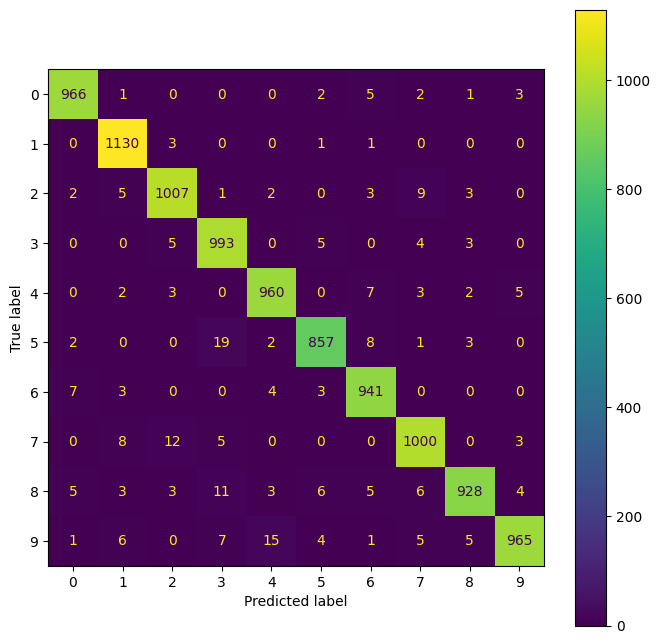

           DEBUG    findfont: Matching                                                         ]8;id=312481;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=707299;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1411\1411]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    12.0.                                                                                          

           DEBUG    findfont:                                                                  ]8;id=52965;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=316822;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf',                                            
                    name='STIXSizeFiveSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=345140;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=37055;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal',                          
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=518969;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=321538;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu                          
                    Sans', style='oblique', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 1.335                                                                      

           DEBUG    findfont:                                                                  ]8;id=600954;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=872440;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=205774;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=626657;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans',                       
                    style='oblique', variant='normal', weight=400, stretch='normal',                               
                    size='scalable')) = 1.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=213592;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=421444;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu                          
                    Serif', style='italic', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=216070;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=177600;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans                        
                    Mono', style='normal', variant='normal', weight=700, stretch='normal',                         
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=135819;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=402377;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=411002;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=586784;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral',                        
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=837842;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=507357;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif',                        
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=608569;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=288452;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans',                          
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 0.33499999999999996                                                        

           DEBUG    findfont:                                                                  ]8;id=940683;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=899723;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif',                      
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=933551;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=315281;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf',                                            
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=967199;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=867342;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode',                         
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=27581;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=345451;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf',                                           
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=221450;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=986503;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans                          
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=314275;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=981635;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=616604;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=855843;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=615625;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=575666;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral',                           
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=408386;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=25857;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=98356;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=576121;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=627328;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=242928;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=838909;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=212433;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral',                        
                    style='italic', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=228665;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=128884;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal',                        
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=559414;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=768116;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode',                         
                    style='italic', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=212717;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=597388;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral',                              
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=894088;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=936773;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf',                                           
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=700,                         
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=656934;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=643297;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif',                             
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=7983;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=462133;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans                     
                    Mono', style='oblique', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=783589;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=166734;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym',                      
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=232046;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=666994;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf',                                            
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=212551;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=863876;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans',                               
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 0.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=464648;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=168341;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode',                            
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=583548;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=352015;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu                      
                    Sans Mono', style='oblique', variant='normal', weight=700,                                     
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=743270;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=632791;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif                        
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=957455;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=865491;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal',                          
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=241501;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=124297;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=238813;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=421884;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/AI_Py_3_10/lib/python3.10/site-packages/ma                     
                    tplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode',                      
                    style='italic', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=168710;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=661964;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Semibold.ttf                     
                    ', name='Source Code Pro', style='normal', variant='normal', weight=600,                       
                    stretch='normal', size='scalable')) = 10.24                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-L.ttf',   ]8;id=125407;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=580235;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-M.ttf',   ]8;id=484812;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=933293;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=360119;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=170925;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf',                         
                    name='Ubuntu Condensed', style='normal', variant='normal', weight=400,                         
                    stretch='condensed', size='scalable')) = 10.25                                                 

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-R.ttf',   ]8;id=4813;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=871399;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=57519;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=325387;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=939287;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=870801;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Regular.ttf'                     
                    , name='Source Code Pro', style='normal', variant='normal', weight=400,                        
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/DejaVuSans.ttf', ]8;id=888394;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=128155;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=80541;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=500498;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',                      
                    name='DejaVu Serif', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=357240;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=329099;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=726957;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=360267;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-LI.ttf',  ]8;id=521172;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=291981;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=297345;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=696697;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-MI.ttf',  ]8;id=131261;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=492157;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=735218;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=165425;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-BI.ttf',                            
                    name='Ubuntu Mono', style='italic', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=409651;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=738099;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-MediumIt.ttf                     
                    ', name='Source Code Pro', style='italic', variant='normal', weight=500,                       
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=327668;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=25418;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-ExtraLightIt                     
                    .ttf', name='Source Code Pro', style='italic', variant='normal',                               
                    weight=200, stretch='normal', size='scalable')) = 11.24                                        

           DEBUG    findfont:                                                                  ]8;id=291197;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=512767;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf                     
                    ', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=671970;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=780242;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/Inconsolata-Bold.ttf',                         
                    name='Inconsolata', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=175465;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=501805;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-ExtraLight.t                     
                    tf', name='Source Code Pro', style='normal', variant='normal', weight=200,                     
                    stretch='normal', size='scalable')) = 10.24                                                    

           DEBUG    findfont:                                                                  ]8;id=429504;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=489874;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-R.ttf',                             
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-BI.ttf',  ]8;id=122360;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=324443;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=863852;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=68922;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',                        
                    name='Ubuntu', style='normal', variant='normal', weight=250,                                   
                    stretch='normal', size='scalable')) = 10.1925                                                  

           DEBUG    findfont:                                                                  ]8;id=733234;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=729324;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Light.ttf',                      
                    name='Source Code Pro', style='normal', variant='normal', weight=300,                          
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-B.ttf',   ]8;id=104342;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=215062;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='normal', variant='normal', weight=700,                                   
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=332070;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=119936;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-RI.ttf',                            
                    name='Ubuntu Mono', style='italic', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-RI.ttf',  ]8;id=604725;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=385615;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont: score(FontEntry(fname='/home/mg/anaconda3/fonts/Ubuntu-C.ttf',   ]8;id=592768;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=604713;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    name='Ubuntu Condensed', style='normal', variant='normal', weight=400,                         
                    stretch='condensed', size='scalable')) = 10.25                                                 

           DEBUG    findfont:                                                                  ]8;id=449496;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=421639;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=160480;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=442219;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.tt                     
                    f', name='DejaVu Sans', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 0.33499999999999996                                      

           DEBUG    findfont:                                                                  ]8;id=390087;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=887085;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=568056;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=441646;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/UbuntuMono-B.ttf',                             
                    name='Ubuntu Mono', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=629124;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=627635;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Medium.ttf',                     
                    name='Source Code Pro', style='normal', variant='normal', weight=500,                          
                    stretch='normal', size='scalable')) = 10.145                                                   

           DEBUG    findfont:                                                                  ]8;id=439685;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=83352;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-BoldIt.ttf',                     
                    name='Source Code Pro', style='italic', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=720549;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=145657;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=300,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=205064;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=137233;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Bold.ttf',                       
                    name='Source Code Pro', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=959077;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=942547;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.t                     
                    tf', name='DejaVu Serif', style='normal', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=117349;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=284008;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-BlackIt.ttf'                     
                    , name='Source Code Pro', style='italic', variant='normal', weight=900,                        
                    stretch='normal', size='scalable')) = 11.525                                                   

           DEBUG    findfont:                                                                  ]8;id=960567;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=731021;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=700,                            
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=468794;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=281078;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=70757;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=866664;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-MI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=500,                                   
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=847767;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=751782;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/Inconsolata-Regular.ttf',                      
                    name='Inconsolata', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=632369;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=697835;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    d.ttf', name='DejaVu Sans Mono', style='normal', variant='normal',                             
                    weight=700, stretch='normal', size='scalable')) = 10.335                                       

           DEBUG    findfont:                                                                  ]8;id=541308;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=432711;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=719746;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=266806;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=526385;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=75745;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-SemiboldIt.t                     
                    tf', name='Source Code Pro', style='italic', variant='normal', weight=600,                     
                    stretch='normal', size='scalable')) = 11.24                                                    

           DEBUG    findfont:                                                                  ]8;id=118628;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=111303;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',                       
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=514960;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=492688;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-It.ttf',                         
                    name='Source Code Pro', style='italic', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=297426;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=603559;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-LightIt.ttf'                     
                    , name='Source Code Pro', style='italic', variant='normal', weight=300,                        
                    stretch='normal', size='scalable')) = 11.145                                                   

           DEBUG    findfont:                                                                  ]8;id=927586;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=370424;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/anaconda3/fonts/SourceCodePro-Black.ttf',                      
                    name='Source Code Pro', style='normal', variant='normal', weight=900,                          
                    stretch='normal', size='scalable')) = 10.525                                                   

           DEBUG    findfont: Matching                                                         ]8;id=90182;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=96259;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/font_manager.py#1454\1454]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    12.0 to DejaVu Sans                                                                            
                    ('/home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/mpl-data/fon                     
                    ts/ttf/DejaVuSans.ttf') with score of 0.050000.                                                

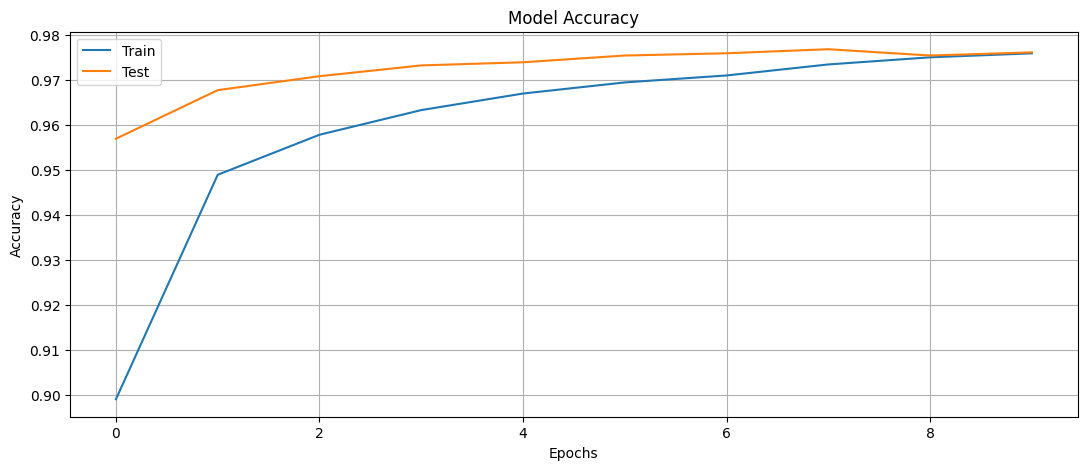

[None]

In [14]:

[x.summarise() for x in models]

# Divide data to one per class
## remember that all classes should be equally available in train and test data!
# I need to get two variants. First will have only proper instances of valid class. Second will have mixed of non valid from each other class.

1) Calculate length of the occurences of examples
2) calculate length of the occurences of examples divided by length of unique classes
3) Now combine those examples that are not from given class.

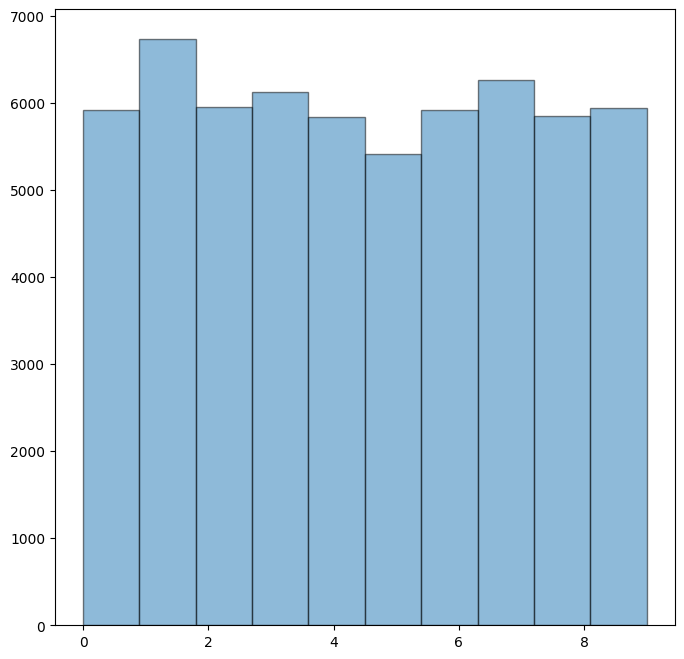

In [15]:
plt.figure(figsize=(8, 8))
plt.hist(y_train, alpha=0.5, histtype='bar', ec='black')
plt.show()

In [16]:
# Get

In [17]:
(_1_x_train, _1_y_train), (_1_x_valid, _1_y_valid) = tf.keras.datasets.mnist.load_data()
_1_x_train = _1_x_train.reshape(60000, 784).astype('float32') / 255       # 784 = 28*28
_1_x_valid = _1_x_valid.reshape(10000, 784).astype('float32') / 255


In [18]:
classes = range(10)

In [19]:

def remove_x_from_dataset(x, y, imbalance_class, imbalance_ratio):
    imbalance_class_idx = np.where(y == imbalance_class)[0]

    # shuffle
    random.shuffle(imbalance_class_idx)    
    len_to_remove = len(imbalance_class_idx) - imbalance_ratio
    imbalance_class_idx = imbalance_class_idx[0:len_to_remove]

    x_im = np.delete(x, imbalance_class_idx, axis=0)
    y_im = np.delete(y, imbalance_class_idx)

    return x_im, y_im

# Only where the input is not 0 class...
def get_per_class(x_train,y_train,current_class, occurence_per_class):
    x_train_im, y_train_im = remove_x_from_dataset(_1_x_train, _1_y_train, 0, occurence_per_class)
    for _class in classes:
        if current_class != _class :
                if _class != 0 :
                    x_train_im, y_train_im = remove_x_from_dataset(x_train_im, y_train_im, _class, occurence_per_class)
    return x_train_im,y_train_im
def combine_y_x(x, y, imbalance_class):
    non_class = np.where(y != imbalance_class)[0]
    _class = np.where(y == imbalance_class)[0]

    y[non_class] = 0
    y[_class] = 1
    return x, y

In [20]:
data = []
for current_class in range(1,10):
    occurence_per_class_train = int(np.ceil(len(np.where(_1_y_train == current_class)[0])/max(classes)))
    _1_x_train_im, _1_y_train_im = get_per_class(_1_x_train,_1_y_train,current_class,occurence_per_class_train)
    _x_train,_y_train = combine_y_x(_1_x_train_im,_1_y_train_im, current_class)
    
    occurence_per_class_valid = int(np.ceil(len(np.where(_1_y_valid == current_class)[0])/max(classes)))
    _1_x_valid_im, _1_y_valid_im = get_per_class(_1_x_valid,_1_y_valid,current_class,occurence_per_class_valid)
    _x_valid,_y_valid = combine_y_x(_1_x_valid_im,_1_y_valid_im, current_class)
    data.append((( _x_train,_y_train),(_x_valid,_y_valid)))

In [21]:
def build_one_classification_model(hyperparams, name):
    model = tf.keras.Sequential(name=name)
    model.add(Input((hyperparams.input_dim,)))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(hyperparams.output_layers, activation = 'sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [22]:
_models = []
hyperparams_one = HyperParameters(droputs = 0.2,output_layers = 1,epochs = 10,bach_size = 16,input_dim = 784)
counter = 0
for _i, _data in enumerate(data):
    model_name = "ClassificationModel_" + str(_i)
    one_model = build_one_classification_model(hyperparams_one, model_name)
    x_valid = _data[1][0]
    y_valid = _data[1][1]

    _models.append(ModelWrapper(model_name, one_model, x_valid, y_valid, hyperparams_one))

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


In [23]:
for _i, _data in enumerate(data):
    _x_train = _data[0][0]
    _y_train = _data[0][1]
    _models[_i].fit(x_train,y_train)


[15:15:07] INFO     ClassificationModel_0 | Model fitting!                                         ]8;id=137578;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=531669;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:15:54] INFO     ClassificationModel_1 | Model fitting!                                         ]8;id=728228;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=128341;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:16:39] INFO     ClassificationModel_2 | Model fitting!                                         ]8;id=495514;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=197933;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:17:24] INFO     ClassificationModel_3 | Model fitting!                                         ]8;id=86538;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=963955;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:18:10] INFO     ClassificationModel_4 | Model fitting!                                         ]8;id=104488;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=161173;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:18:54] INFO     ClassificationModel_5 | Model fitting!                                         ]8;id=487298;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=311838;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:19:42] INFO     ClassificationModel_6 | Model fitting!                                         ]8;id=392639;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=108592;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:20:33] INFO     ClassificationModel_7 | Model fitting!                                         ]8;id=339695;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=32880;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

[15:21:20] INFO     ClassificationModel_8 | Model fitting!                                         ]8;id=857779;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=884168;file:///tmp/ipykernel_124827/3594805373.py#48\48]8;;\

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step


[15:22:06] INFO     ClassificationModel_0 | Model summary:                                         ]8;id=739462;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=525483;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_0 | Classification report:                                 ]8;id=518901;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=299689;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=482149;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=957441;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25      1143                                          
                               1       0.00      0.00      0.00      6742                                          
                                                                                                                   
                        accuracy                           0.14      7885                                          
                       macro avg       0.07      0.50      0.13      7885                                          
                    weighted avg       0.02      0.14      0.04      7885                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7dfc6721d0>               ]8;id=631307;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=721449;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


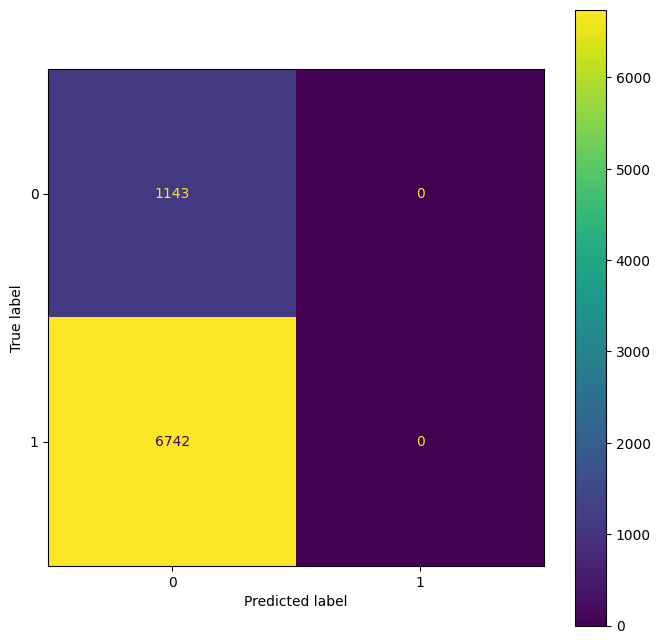

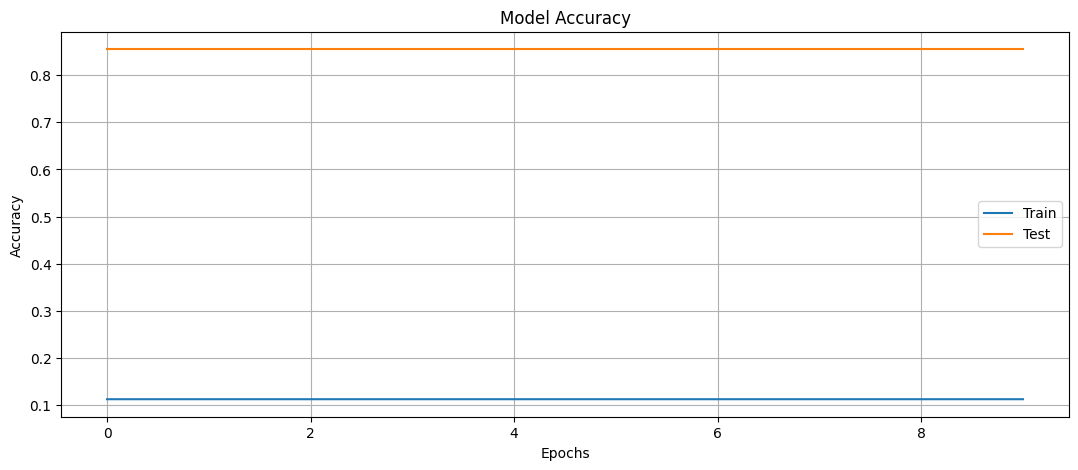

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


[15:22:07] INFO     ClassificationModel_1 | Model summary:                                         ]8;id=321798;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=951565;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_1 | Classification report:                                 ]8;id=874119;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=168064;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=15632;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=59564;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.15      1.00      0.26      1035                                          
                               1       0.00      0.00      0.00      5958                                          
                                                                                                                   
                        accuracy                           0.15      6993                                          
                       macro avg       0.07      0.50      0.13      6993                                          
                    weighted avg       0.02      0.15      0.04      6993                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17e53340>               ]8;id=227194;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=935417;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


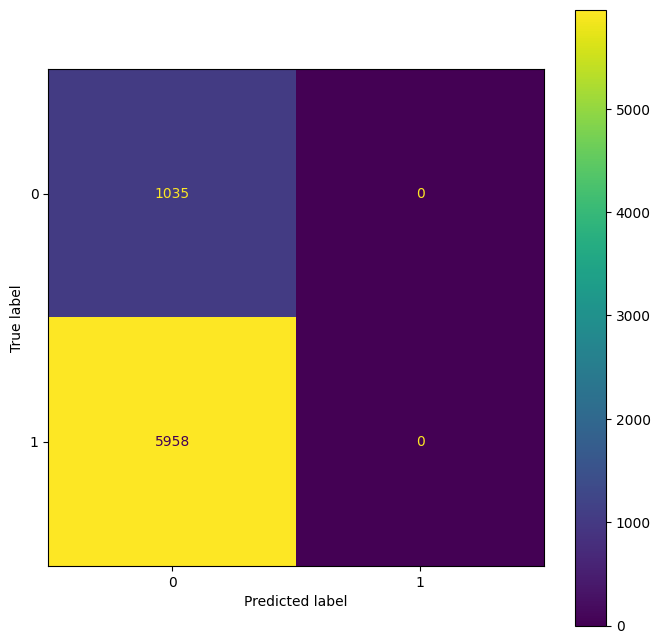

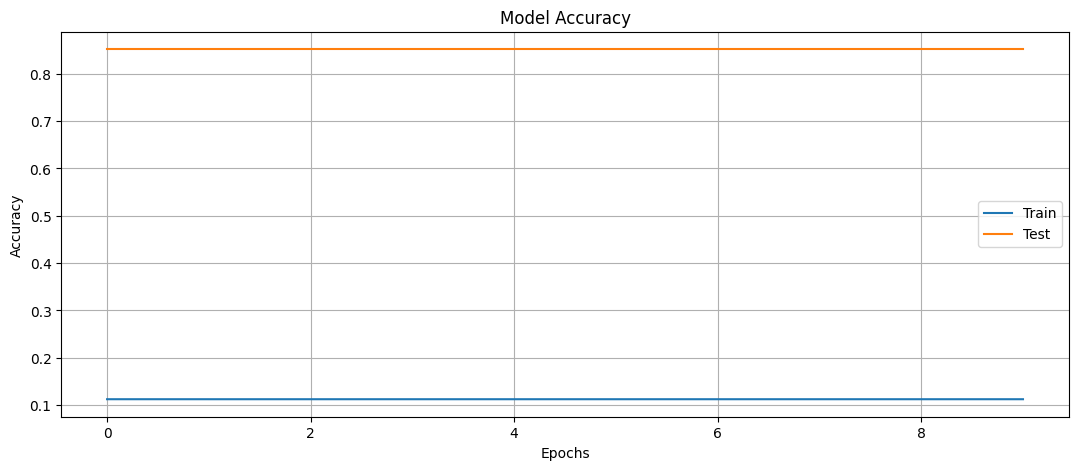

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


           INFO     ClassificationModel_2 | Model summary:                                         ]8;id=200326;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=448240;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_2 | Classification report:                                 ]8;id=990663;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=404503;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[15:22:08] INFO                   precision    recall  f1-score   support                          ]8;id=846149;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=22978;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25      1017                                          
                               1       0.00      0.00      0.00      6131                                          
                                                                                                                   
                        accuracy                           0.14      7148                                          
                       macro avg       0.07      0.50      0.12      7148                                          
                    weighted avg       0.02      0.14      0.04      7148                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17d85840>               ]8;id=838302;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=872214;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


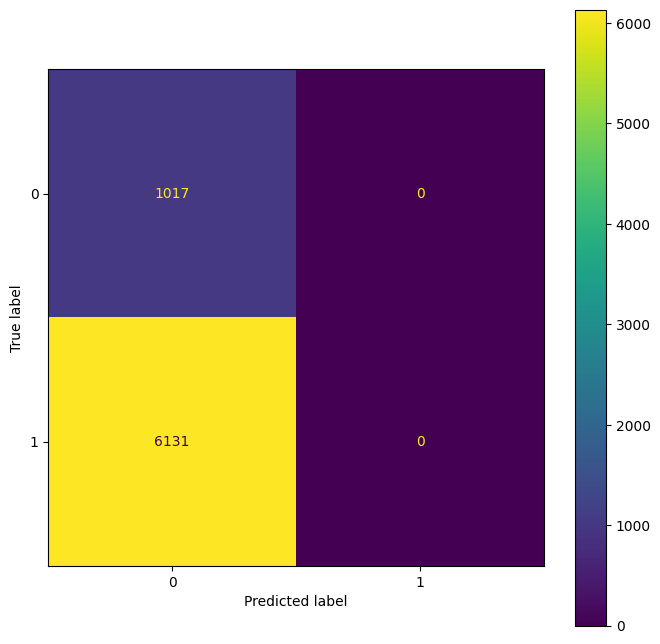

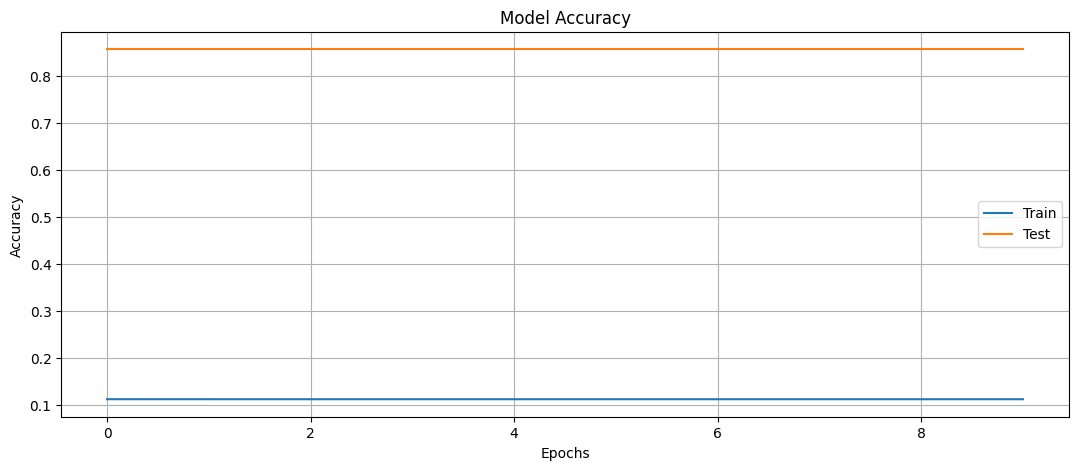

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


           INFO     ClassificationModel_3 | Model summary:                                         ]8;id=271648;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=275153;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_3 | Classification report:                                 ]8;id=215960;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=449;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[15:22:09] INFO                   precision    recall  f1-score   support                          ]8;id=271231;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=366754;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25       990                                          
                               1       0.00      0.00      0.00      5842                                          
                                                                                                                   
                        accuracy                           0.14      6832                                          
                       macro avg       0.07      0.50      0.13      6832                                          
                    weighted avg       0.02      0.14      0.04      6832                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17cbb940>               ]8;id=133499;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=995983;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


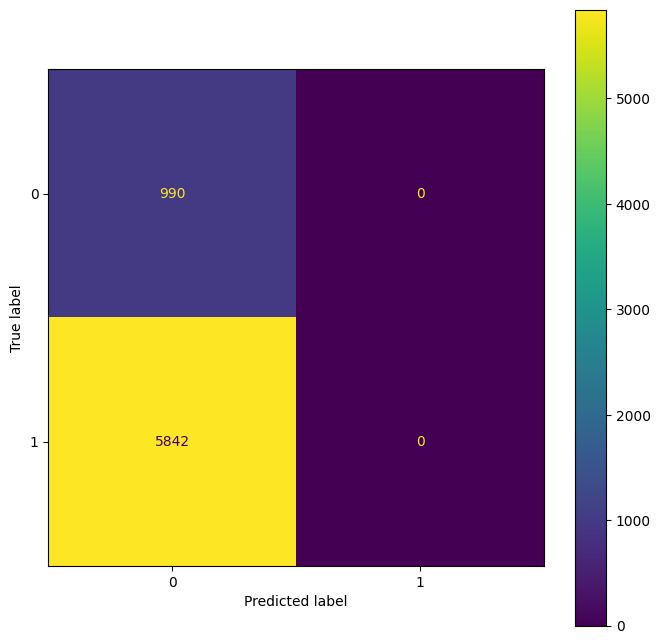

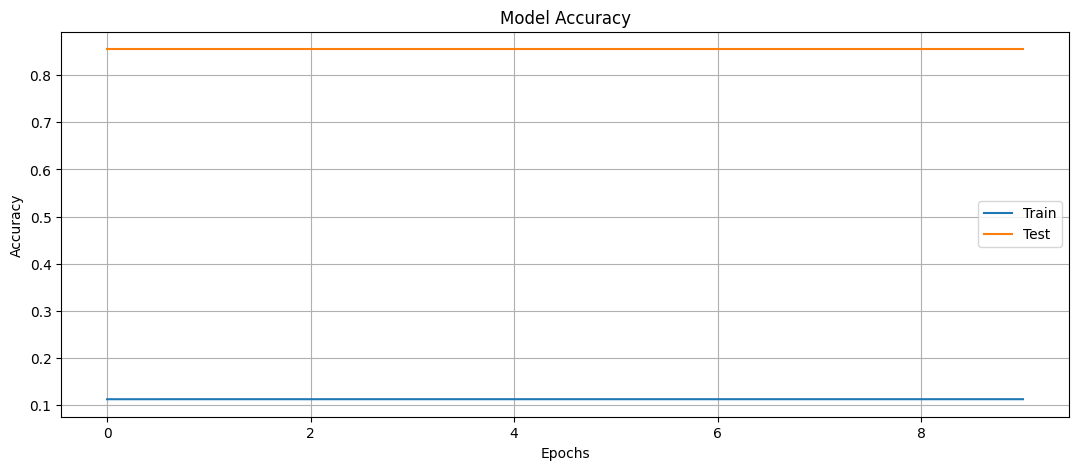

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


           INFO     ClassificationModel_4 | Model summary:                                         ]8;id=801716;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=38350;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_4 | Classification report:                                 ]8;id=916217;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=970087;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=951677;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=337782;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25       900                                          
                               1       0.00      0.00      0.00      5421                                          
                                                                                                                   
                        accuracy                           0.14      6321                                          
                       macro avg       0.07      0.50      0.12      6321                                          
                    weighted avg       0.02      0.14      0.04      6321                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17b355d0>               ]8;id=293733;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=766186;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


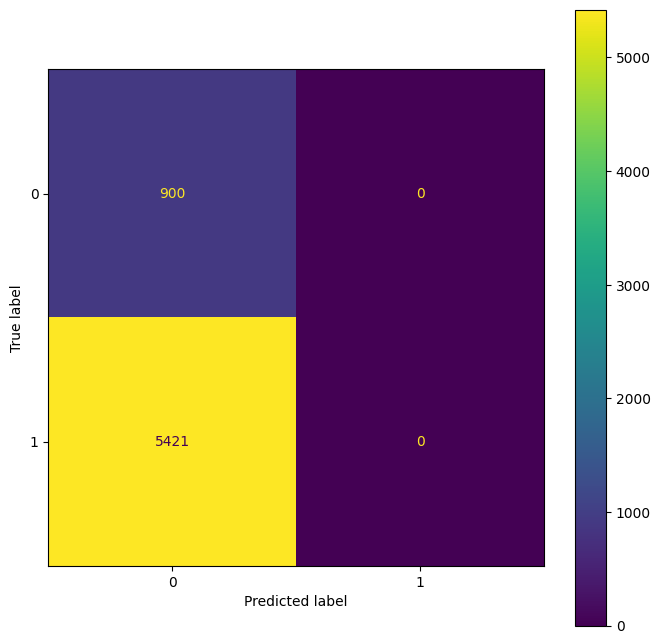

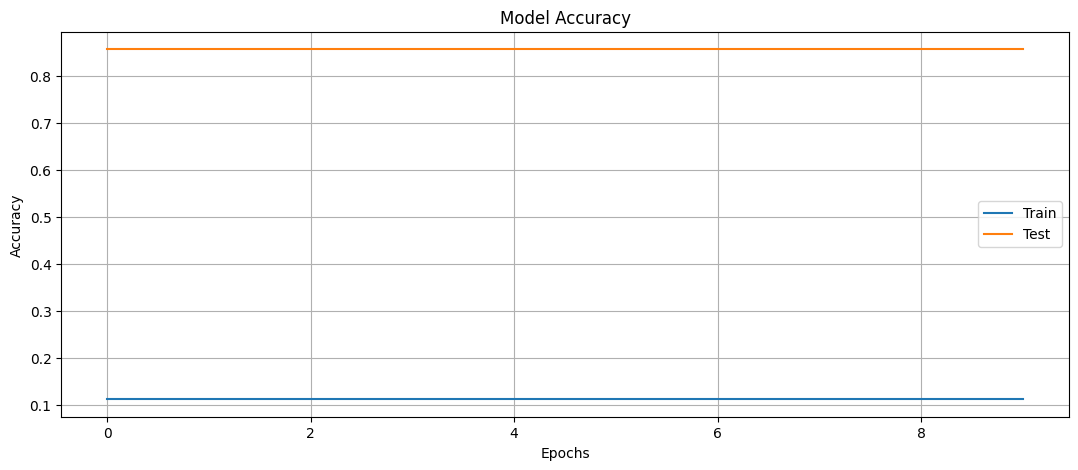

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


[15:22:10] INFO     ClassificationModel_5 | Model summary:                                         ]8;id=577804;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=756903;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_5 | Classification report:                                 ]8;id=854650;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=740573;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=417439;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=478337;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25       963                                          
                               1       0.00      0.00      0.00      5918                                          
                                                                                                                   
                        accuracy                           0.14      6881                                          
                       macro avg       0.07      0.50      0.12      6881                                          
                    weighted avg       0.02      0.14      0.03      6881                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e444a3460>               ]8;id=616901;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=87070;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


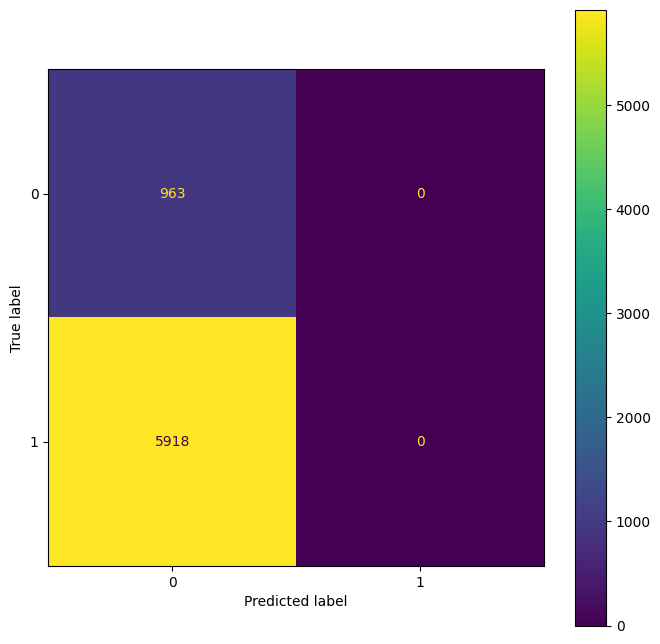

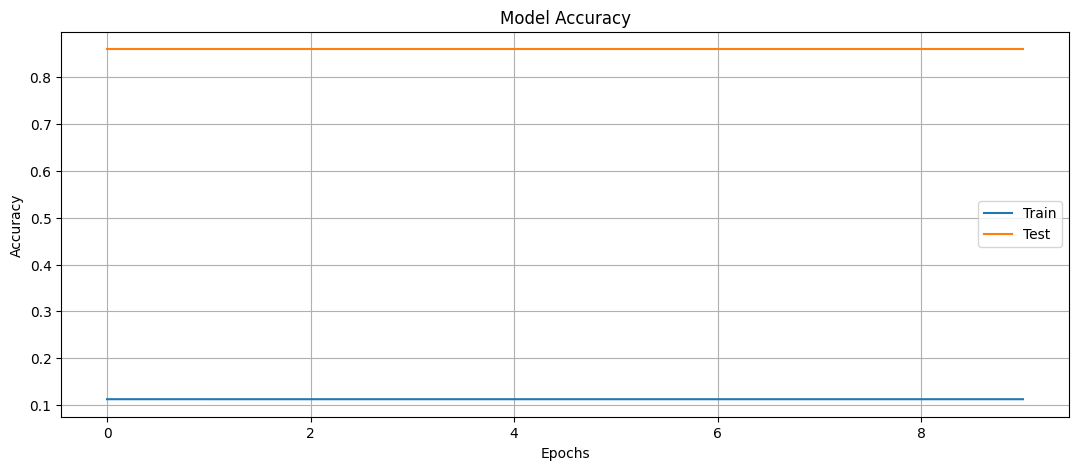

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


[15:22:11] INFO     ClassificationModel_6 | Model summary:                                         ]8;id=832043;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=184205;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_6 | Classification report:                                 ]8;id=569521;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=716406;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=976874;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=966035;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25      1035                                          
                               1       0.00      0.00      0.00      6265                                          
                                                                                                                   
                        accuracy                           0.14      7300                                          
                       macro avg       0.07      0.50      0.12      7300                                          
                    weighted avg       0.02      0.14      0.04      7300                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17e1bbb0>               ]8;id=468849;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=686361;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


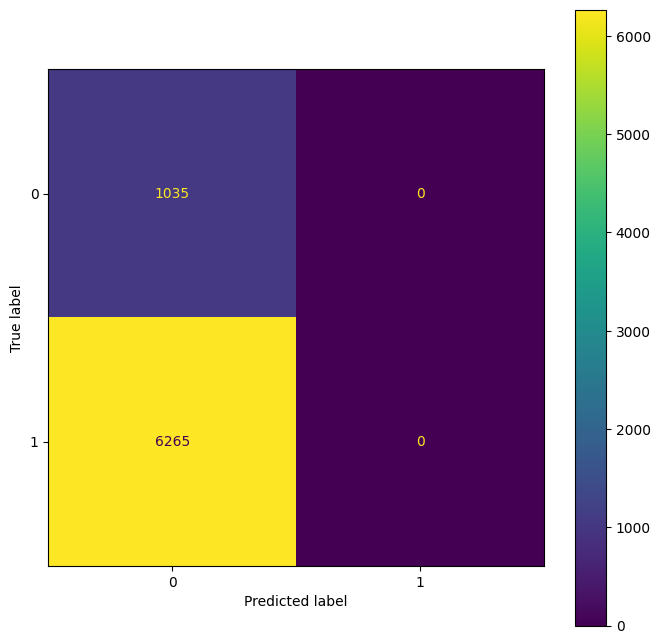

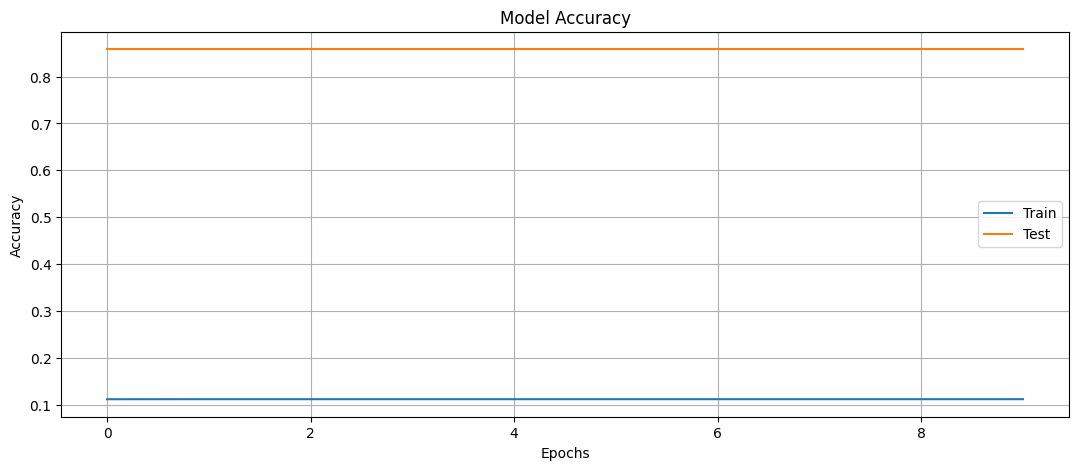

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


           INFO     ClassificationModel_7 | Model summary:                                         ]8;id=588427;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=956336;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_7 | Classification report:                                 ]8;id=511703;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=828320;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[15:22:12] INFO                   precision    recall  f1-score   support                          ]8;id=704424;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=896944;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.14      1.00      0.25       981                                          
                               1       0.00      0.00      0.00      5851                                          
                                                                                                                   
                        accuracy                           0.14      6832                                          
                       macro avg       0.07      0.50      0.13      6832                                          
                    weighted avg       0.02      0.14      0.04      6832                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e17f70e50>               ]8;id=468663;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=880773;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


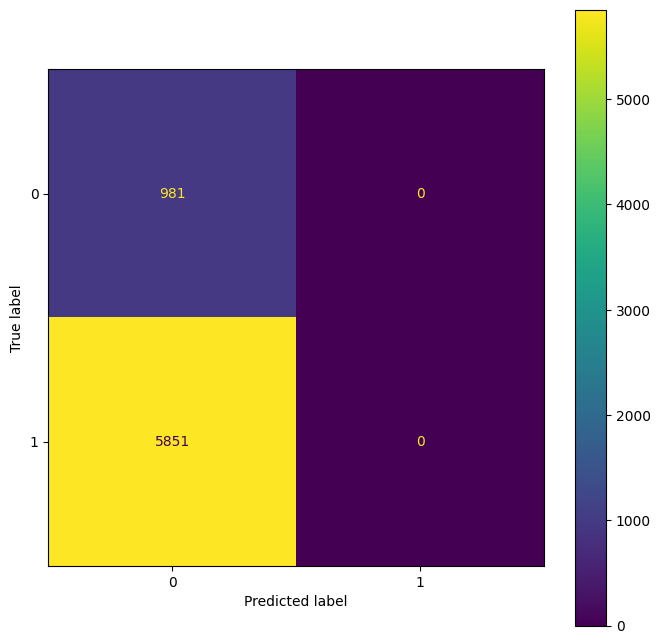

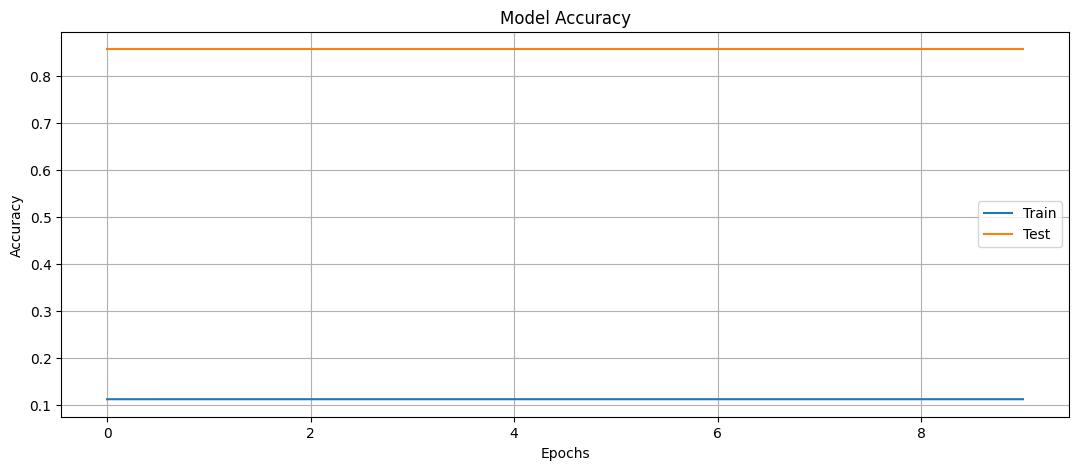

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


           INFO     ClassificationModel_8 | Model summary:                                         ]8;id=96471;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=242995;file:///tmp/ipykernel_124827/3594805373.py#36\36]8;;\
                                                                                                                   

Model: "ClassificationModel_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,805 (921.12 KB)

 Trainable params: 78,601 (307.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,204 (614.08 KB)

           INFO     ClassificationModel_8 | Classification report:                                 ]8;id=726528;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=987387;file:///tmp/ipykernel_124827/3594805373.py#38\38]8;;\
                                                                                                                   

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mg/AI_Py_3_10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           INFO                   precision    recall  f1-score   support                          ]8;id=483744;file:///tmp/ipykernel_124827/3594805373.py\3594805373.py]8;;\:]8;id=414625;file:///tmp/ipykernel_124827/3594805373.py#40\40]8;;\
                                                                                                                   
                               0       0.15      1.00      0.25      1017                                          
                               1       0.00      0.00      0.00      5949                                          
                                                                                                                   
                        accuracy                           0.15      6966                                          
                       macro avg       0.07      0.50      0.13      6966                                          
                    weighted avg       0.02      0.15      0.04      6966                                          
                                                                                                                   

           DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f7e163f7250>               ]8;id=619971;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=490301;file:///home/mg/AI_Py_3_10/lib/python3.10/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_124827/3594805373.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  _fig.show()


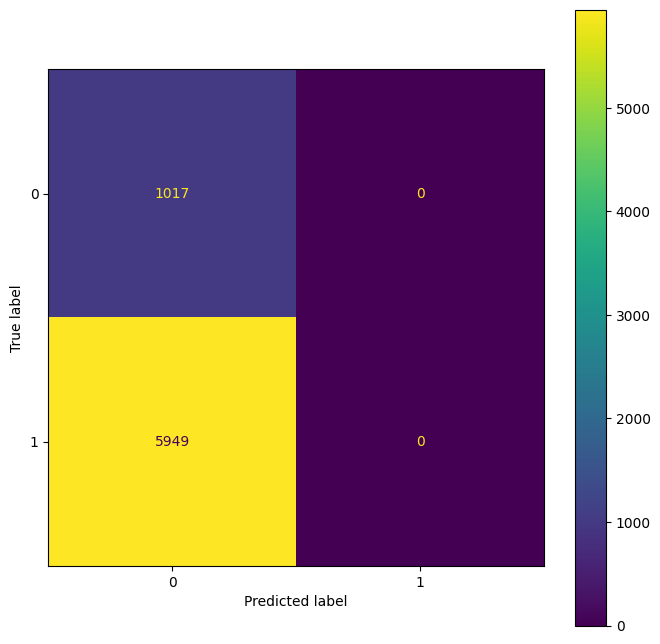

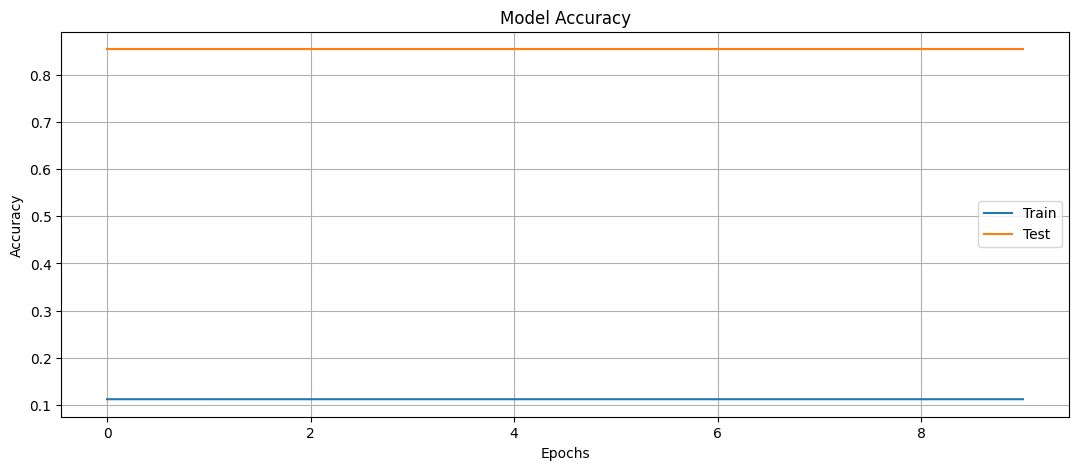

[None, None, None, None, None, None, None, None, None]

In [24]:
[x.summarise() for x in _models]